In [3]:
from pathlib import Path
import json
import pandas as pd
import re
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# Hypothesis Testing: Does The Hot Hand Effect Exist?

In basketball, the "hot hands effect" is a supposed phenomenon in which a person who makes several successful baskets in a row experiences a greater probability of scoring in further attempts.  For example, a player who has "made" three sucessful baskets in a row is considered to have a higher probability of making a 4th basket than if they had just missed a shot. In this notebook, we'll use 0 to represent a missed basket and 1 to represent a made basket. Restating the hot hands effect in these terms, under the hot hands theory, a player whose last three shots were `'111'` (three consecutive makes) has a higher chance of making a fourth basket than if their last three shots were `'110'`.  The failed third shot "resets" their hot hands.

The notion of a hot hand is often considered to be a cognitive fallacy, a tendency for our brains to ascribe more meaning to a random sequence of shots than it rightly should.  People have taken many different approaches to this topic.  This notebook shows how one can use statistical testing tools to test the existence of the hot hands effect in basketball.

## The Data

Shot records for the Golden State Warriors (our local NBA basketball team) from the 2016-2017 season are located in the `data_dir` path.  The files are stored in `json` format and are named '{match_date}0{team}.json'.  `match_date` is the date of the game and `team` is either 'GSW' or the abbreviation for the opposing team.  The structure of the data is simple: each file holds shot records for a single game in key/value pairs.  The keys are player names and the values are ordered arrays of shot attempts.  A `1` represents a "make" (successful attempt) and a `0` is a "miss" (failed attempt).  Although this will perhaps overly simplify the analysis, for this assignment, we will not differentiate between 2-point attempts (2FGA), 3-point attempts (3FGA), and free-throws (FT).

#### Json to DF

Defined below is a function that takes a json file and builds a dataframe where each row of the table represents the information about shots for each player. The table has three columns `player`, `shots`, and `game`, described below:

* `player`: strings, player name
* `shots`: strings, the sequence of attempted shots concatenated into a single string e.g. '110101'.
* `game`: strings, the name of the json file (without the .json extension)


In [5]:
def game_json_to_game_df(json_filename):
    with open(json_filename) as f:
        data = json.load(f)
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df.reset_index()
    df = df.fillna("")
    df.iloc[:, 1] = df.iloc[:, 1].astype(str)
    for i in range(1, len(df.columns) - 1):
        df.iloc[:, 1] = df.iloc[:, 1] +  df.iloc[:, i + 1].map(str).str.replace(".0", "")
    data = {"game": [json_filename.stem]*len(df), "shots": df.iloc[:, 1], "player": df.iloc[:, 0]}
    game_df = pd.DataFrame(data, columns = ["player", "shots", "game"])
    return game_df

#### Creating Shot Dataframe

We will now read in all 99 `json` files and combine them into a single data frame called `unindexed_shot_data`. This dataframe has the exact same structure as above. After, we create a multi-index table so we can perform hierarchical indexing.

In [10]:
import os, zipfile
data_dir = Path('data/2017')
df = []
for item in os.listdir(data_dir):
    df.append(game_json_to_game_df(Path("data/2017/" + item)))
unindexed_shot_data = pd.concat(df, ignore_index = True)


In [11]:
shot_data = unindexed_shot_data.set_index(['game', 'player'])
shot_data.head(5)

shots
game         player                       
201610250GSW A. Iguodala               001
             A. Varejao                 01
             D. Bertans                 11
             D. Dedmon                0010
             D. Green     0010011110100111

## The Hypothesis

Our __null hypothesis__ is that there is no hot hands effect, meaning that the probability of making shots do not change when a player makes several baskets in a row.  In this null world, every permutation of a given shot sequence is equally likely.  For example `'00111'` is just as likely as `'10101'`, `'10011'`, and `'01101'`.  In a universe where hot hands exists, the first sequence would be more likely than the other three.

## Understanding the Data

Let's take a look at [Klay Thompson's shooting performance from Dec. 5, 2016 versus the Indiana Pacers](https://www.basketball-reference.com/play-index/shooting.fcgi?player_id=thompkl01&year_id=2017&opp_id=IND&game_location=H).  Klay scored 60 points in 29 minutes of playing time. In the [entire history of professional basketball](https://www.basketball-reference.com/play-index/pgl_finder.cgi?request=1&match=game&is_playoffs=N&age_min=0&age_max=99&pos_is_g=Y&pos_is_gf=Y&pos_is_f=Y&pos_is_fg=Y&pos_is_fc=Y&pos_is_c=Y&pos_is_cf=Y&c1stat=mp&c1comp=lt&c1val=30&order_by=pts), nobody has come close (note these records are spotty before 1983). 

During this game, Klay took a total of 44 shots, landing 10/11 1 point free-throws, 13/19 2 point shots, and 8/14 3 point shots. [At least one news story](https://www.usatoday.com/story/sports/nba/warriors/2016/12/06/klay-thompson-60-points-outburst-by-the-numbers-warriors-pacers/95030316/) specifically called him out as having a 'hot hand' during this game.

We'll start by looking at this game to make sure we understanding the structure of the data.

#### Shot Sequence

We first summarize Klay's sequence of shot results.

In [12]:
klay_example = shot_data.loc[('201612050GSW', 'K. Thompson'), 'shots']
klay_example

'11011110010111111001110111101110111101010101'

In [13]:
attempts_ex = len(klay_example)
makes_ex = len(re.findall("1", klay_example))
accuracy_ex = makes_ex/attempts_ex

print(f"""
attempts:  {attempts_ex}
makes:     {makes_ex}
accuracy:  {round(accuracy_ex, 2)}
""")


attempts:  44
makes:     31
accuracy:  0.7



We might be interested in the number of runs of various lengths that Thompson makes over the course of the game.  A run of length k is defined as k consecutive successes in a row.  We will include overlapping runs in our counts.  For example, the shot record `'1111'` contains three runs of length 2: <span style="background-color:yellow"><b>11</b></span>11, 1<span style="background-color:yellow"><b>11</b></span>1, 11<span style="background-color:yellow"><b>11</b></span>).

#### Runs of Length k



In [14]:
run_length_2 = len(re.findall("(?<=1)1", klay_example))

print(f"""
Klay Thompson made {run_length_2} runs of length 2 in the game against the Indiana Pacers.
""")


Klay Thompson made 19 runs of length 2 in the game against the Indiana Pacers.



In [15]:
run_length_3 = len(re.findall("(?<=11)1", klay_example))

print(f"""
Klay Thompson made {run_length_3} runs of length 3 in the game against the Indiana Pacers.
""")


Klay Thompson made 12 runs of length 3 in the game against the Indiana Pacers.




Let's generalize the work we did above by writing a function `count_runs`. `count_runs` takes two arguments:

* `shot_sequences`: a pandas series of strings, each representing a sequence of shots for a player in a game
* `run_length`: integer, the run length to count

`count_runs` returns a pandas series, where the ith element is the number of occurrences of `run_length` in the ith sequence in `shot_sequences`.


In [18]:
def count_runs(shot_sequences, run_length):
    """
    Counts consecutive occurences of an event
    
    shot_sequences: a pandas series of strings, each representing a sequence of shots for a player in a game
    run_length: integer, the run length to count
    
    return: pd.Series of the number of times a run of length run_length occurred in each shot_sequence
    """
    counts = []
    string = "(?<=" + "1"*(run_length - 1) + ")1"
    if type(shot_sequences) == str:
        shot_sequences = pd.Series(shot_sequences)
    for i in shot_sequences:
        counts.append(len(re.findall(string, i)))
    df = pd.Series(counts)
    return df

We will now use `count_runs` to transform the data as follows: for each player, we count the number of times they have made a run of length $k$ where $k = 1, 2, 3, ..., 10$.  The column names are `str(k)` and the index is the player names.

In [21]:
df = pd.DataFrame(columns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
for i in np.arange(1, 11):
    df[i] = count_runs(unindexed_shot_data["shots"], i)
df.index = unindexed_shot_data["player"]
df.columns = df.columns.map(str)
run_counts = df.groupby(by = "player").sum()
run_counts.head()

,1,2,3,4,5,6,7,8,9,10
player,,,,,,,,,,
A. Abrines,8,3,0,0,0,0,0,0,0,0
A. Afflalo,7,0,0,0,0,0,0,0,0,0
A. Ajinca,12,6,3,1,0,0,0,0,0,0
A. Aminu,36,16,8,4,1,0,0,0,0,0
A. Anderson,2,1,0,0,0,0,0,0,0,0


## Defining a Test Statistic

People who refer to "hot hands" often treat it as Justice Potter Stewart treats obscenity: ["I know it when I see it."](https://en.wikipedia.org/wiki/I_know_it_when_I_see_it). Instead, we should think about how to quantify the question in an empirically verifiable way.

Unfortunately, it's not immediately clear how we might test the null hypothesis.  In other hypothesis test settings like website A/B testing and drug efficacy, we have obvious choices for important and measurable outcomes to demonstrate increases in revenue or positive health impacts, respectively.

However, the hot hands is not as well-defined, so we're going to try a few things that seem to have the flavor of measuring "streakiness".

#### Length of Longest Run

Our first attempt at a test statistic will be the length of the longest streak. We saw in the previous section that long runs were rare, so perhaps we can use the occurrence of long runs as evidence either for or against the hot hands hypothesis.


In [22]:
def find_longest_run(shot_sequences):
    """
    Finds longest run in a pd.Series of shot_sequences
    
    shot_sequences: pd.Series (string) shot data for a set of games or a single python string
       to be coerced into a pd.Series
    
    return: as pd.Series of the lengths of longest sequences of 1s in each game
    """
    if type(shot_sequences) == str:
        shot_sequences = pd.Series(shot_sequences)    
    counts = []
    for i in shot_sequences:
        lengths = []
        ones = re.findall("1+", i)
        if len(ones) == 0:
            lengths.append(0)
        else:
            for i in ones:
                lengths.append(len(i))
        counts.append(max(lengths))
    return pd.Series(counts)



If we look at the test inputs above, we'll see that the extreme game featuring Klay Thompson scoring 60 points in 29 minutes has a longest run length of 6.

Let's try to understand whether this value for our test statistic is indicative of Klay having a hot hand during this game. To do this, we need to know how 6 stacks up as a streak compared to a player similar to Klay but who definitely does not have a hot hand effect.

Below, we define a function called `bootstrap_longest_run` that simulates the sampling distribution of the `longest_run` test statistic under the null hypothesis given the shot record of a single game.

In [23]:
def bootstrap_longest_run(game, num_iter=1):
    """
    game: string, shot sequence data for a single game
    num_iter: number of statistics to generate
    
    returns: num_iter statistics drawn from the bootstrapped sampling distribution
    """
    score = np.array(list(game))
    bootstrap = []
    for i in range(num_iter):
        samples = np.random.choice(score, len(game))
        sample_score = "".join(samples)
        bootstrap.append(find_longest_run(sample_score)[0])
    return pd.Series(bootstrap)

The p value is 0.8666


C:\Users\Chris Tsai\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


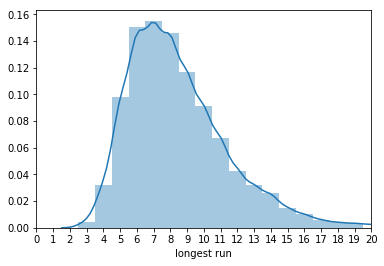

In [27]:
df = bootstrap_longest_run(klay_example, 10000)
x = pd.Series(df, name = "longest run")
ax = sns.distplot(x, bins = np.arange(21)-.5)
plt.xticks(np.arange(0, 21, 1))
plt.xlim(0, 20)
#how does 6 compare to these streaks?
plt.plot()
#we want to see what the probability of getting more than 6 in a row is.
p = np.count_nonzero(x >= 6)/len(x)
print("The p value is " + str(p))

The p-value is .866 which is way higher than our significance level of 0.05. We can conclude that we are unable to reject the null hypothesis. Our p-value means that the probability of a run as long as 6 or longer than 6 is .866. Our problem here is that we did not pick a very good test statistic.

## A Different Statistic

Arguably, the longest run isn't a particularly good test-statistic for capturing what people mean when they say "hot hands". 

Let's try a test-statistics that captures the essence of "hot-hands" a bit more.  We're now going to explore a well-known approach proposed by [Amos Tversky](https://en.wikipedia.org/wiki/Amos_Tversky) and his collaborators.  The hot hand of Tversky is similar to the notion of being "on fire" in the old arcade game [NBA Jam](https://www.youtube.com/watch?v=ipzstdPtxNw).  In that game, if you make 3 shots in a row with a player, your player would be on fire (with flame sprites!).  While on fire (until a miss), the player has an inflated probability of making shots.

The statistic to capture this affect, called $T_{k, make}$, is easy to compute:
\begin{align*}
  T_{k, make}
  & = \hat{\mathbb{P}}(\text{Make next shot}\ \vert\ \text{Made last $k$ shots})\\
  & = \frac{\#\{\text{Streaks of $k+1$ makes in a row}\}}{\#\{\text{Streaks of $k$ makes in a row preceeding an attempt}\}}
\end{align*}
If $T_{k, make}$ is especially high, then we might say that our player is experiencing a hot hand.

A similar statistic can try to capture a cold hand reversal:
\begin{align*}
  T_{k, miss}
  & = \hat{\mathbb{P}}(\text{Make next shot}\ \vert\ \text{Missed last $k$ shots})\\
  & = \frac{\#\{\text{Streaks of $k$ misses followed by make}\}}{\#\{\text{Streaks of $k$ misses in a row preceeding an attempt}\}}
\end{align*}


In [28]:
def count_conditionally(shot_sequences, conditioning_set, event='1'):
    """
    shot_sequences: pd.Series (string) of shot strings for a set of games or a single string
       to be coerced into a pd.Series
    conditioning_set: string or regex pattern representing the conditioning set
    event: string or regex pattern representing the event of interest
    
    return: pd.Series of the number of times event occured after the
       conditioning set in each game
    """
    string = "(?<=" + str(conditioning_set) + ")" + str(event)
    count = []
    if type(shot_sequences) == str:
        shot_sequences = pd.Series(shot_sequences)    
    for i in shot_sequences:
        count.append(len(re.findall(string, i)))
    return pd.Series(count)

## The "Tversky Statistic" for Hot Hand Detection

It turns out that simply measuring $T_k = T_{k, make}$ isn't as useful as the "Tversky statistic" for hot-hand detection, defined as 

$$T_k = T_{k, make} - T_{k, miss}$$

The original inspiration for this statistic was to measure hot-handedness by comparing the proportion of times a player continued a success streak against their propensity to reverse a string of misses. As we saw above, computing the expected value of $T_{k, make}$ is hard and the results are counterintuitive.

The Tversky statistic is sometimes undefined (has no valid value).  In our analysis, we will be discarding sequences where $T_k$ is undefined.  The reason is that it doesn't make sense to count cases where the conditioning set isn't present. The two cases we discard are when:

Case 1:  $T_{k, make}$ is undefined (no streak of k: player never made more than k shots in a row)

Case 2: $T_{k, miss}$ is undefined (no streak of k: player never missed more than k shots in a row)

In [29]:
def calc_tk_stat(games, k):
    """
    Computes the tversky statistic for hot hands
        
    games: pd.Series (string) shot data for a set of games
    k: int, conditioning set length; number of misses/hits to condition on
    """
#the statistic is k,make - k, miss
    k_make_1 = count_conditionally(games, k*"1", "1")
    k_make_0 = count_conditionally(games, k*"1", "0")
    k_miss_1 = count_conditionally(games, k*"0", "1")
    k_miss_0 = count_conditionally(games, k*"0", "0")
    return k_make_1/(k_make_0 + k_make_1) - k_miss_1/(k_miss_1 + k_miss_0)

### Statistically Testing the Null Hypothesis

Now we return to the question of whether or not Thompson has hot hands. Under the hypothesis that he does have hot hands, Klay Thompson has a higher chance of making shots when he has recently made shots. Under the null hypothesis, his chance of making a shot is independent of recent successes.


In [33]:
klay_data = shot_data.loc[pd.IndexSlice[:, 'K. Thompson'], 'shots']

In [34]:
def calc_p_values(observed_statistics, simulated_statistics):
    """
    observed_statistics: pd.Series (float), test statistics for each game 
    simulated_statistics: pd.DataFrame, rows represent games, columns contain 
        test statistics simulated under the null hypothesis 
    
    return: pd.Series (float), p-values for every game between 0 and 1
    """
    final_list = []
    for i in observed_statistics.dropna().index:
        final_list.append(sum(simulated_statistics.loc[i].dropna() >= observed_statistics[i])/len(simulated_statistics.loc[i].dropna()))
    return pd.Series(final_list, index = observed_statistics.dropna().index)


In [35]:
klay_df = pd.DataFrame({1: calc_tk_stat(klay_data, 1), 2: calc_tk_stat(klay_data, 2), 3: calc_tk_stat(klay_data, 3)}, columns = [1, 2, 3])

def bootstrap_p(player, k, num_iter=10000):
    bootstrap_df = pd.DataFrame(columns=list(range(num_iter))) #i want this to be the games
    for i in range(len(player)):
        score = np.array(list(player[i]))
        bootstrap = []
        for x in range(num_iter):
            samples = np.random.choice(score, len(player[i]))
        #samples = np.random.choice(score, len(game), replace=False)
            sample_score = "".join(samples)
            bootstrap.append(sample_score)
        bootstrap_df.loc[i] = calc_tk_stat(pd.Series(bootstrap), k)
    all_p_values = pd.Series(list(calc_p_values(calc_tk_stat(player, k), bootstrap_df)))
    index_values = player.reset_index().loc[~calc_tk_stat(player, k).isna()]['game']
    all_p_values.index = index_values
    return all_p_values
p_k1 = bootstrap_p(klay_data, 1)
p_k2 = bootstrap_p(klay_data, 2)
p_k3 = bootstrap_p(klay_data, 3)


## Summary and Results

#### Model

We modeled Klay Thompson's shot record for each game as sequences of 1's and 0's with a 1 being a shot made and a 0 being a shot missed with the following assumptions:

* Every shot made is considered with equal weight (1) despite distance
* Every shot has the same difficulty and probability

We realize that this ignores the following real-life issues:

* Opposing defenders affect the difficulty of a shot
* Distance affects the difficulty of a shot
* Shot types vary in difficulty (3-pointers, 2-points, free-throws)
* Team mate behavior may create more favorable scoring conditions
* A person who is fouled on a shot attempt and misses still counts as a 0

However, this analysis can be used as a baseline that we can compare more complicated models to.

#### Null Hypothesis

Our null hypothesis is that the hot hands effect does not truly exist, and that the probability of making a shot does not depend on the shooter's previous shots. In terms of our model, this means that a single permutation of a shot sequence should be equally likely as any other permutation.

#### Test Statistic

To test our hypothesis, we used the Tversky statistic, which can be interpreted as the proportion of times a player continues or breaks a shooting streak of k makes minus the proportion of times a player continues or breaks a shooting streak of k misses.  This can be written mathematically as:

$$T_k = T_{k, make} - T_{k, miss}$$

#### Results

Looking Klay's December 5th game against the Pacers, we calculated a p-value of .900 for $k=1$, which is not significant at the 5% level, which means that we are unable to reject the null hypothesis  This can be verified visually in the following plot.



C:\Users\Chris Tsai\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


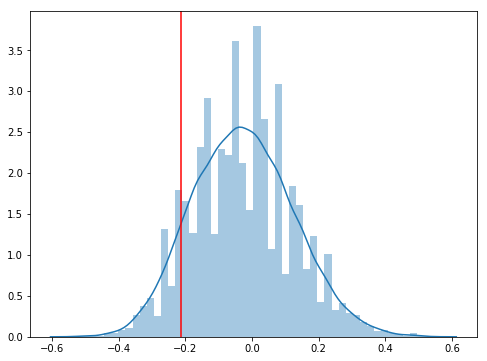

In [36]:
def bootstrap_game(game, k, num_iter=10000):
    score = np.array(list(game))
    bootstrap = []
    for i in range(num_iter):
        samples = np.random.choice(score, len(game))
        sample_score = "".join(samples)
        bootstrap.append(np.array(calc_tk_stat(sample_score, k))[0])
    return pd.Series(bootstrap)

plt.figure(figsize = (8, 6))
plot_1 = bootstrap_game(klay_data["201612050GSW"][0], 1)
sns.distplot(plot_1.dropna())
x_1 = calc_tk_stat(klay_data["201612050GSW"], 1)[0]
plt.axvline(x= x_1, color = 'red')


We go on to analyze all of Thompson's games and find that few of the observations are significant at the 5% level for conditioning sets of length $k=1,2,3$.  The table below shows the number of observations that we discarded due to the statistic being undefined and the number that are significant at each conditioning length.


Player | Number of Games | k | Number of Games Discarded | Number of Games Significant
---      | --- | --- | ---                 | ---
Thompson | 95  | 1   | 0 | 5 
         |  -  | 2   | 3 | 4
         |  -  | 3   | 42 | 3
